In [14]:
# Cell 1: Import necessary libraries and define data path

import os
import scanpy as sc
import anndata as ad
import numpy as np

# Define the path to our downloaded data file
# The 'data_dir' variable stores the name of the directory where our data resides.
data_dir = "data"

# The 'file_name' variable stores the name of the actual data file.
file_name = "5k_pbmc_v3_filtered_feature_bc_matrix.h5"

# We combine the directory and file name to get the full path to our data.
# os.path.join puts together path components, handling slashes correctly across operating systems.
data_path = os.path.join(data_dir, file_name)

# Print the full path to confirm it's correct.
print(f"Attempting to load data from: {data_path}")

# Check if the file actually exists before trying to load it.
# os.path.exists returns True if the file or directory exists, False otherwise.
if os.path.exists(data_path):
    print("File found. Proceeding to load data...")
else:
    print("Error: File not found! Please check the path and filename.")
    print("Make sure '5k_pbmc_v3_filtered_feature_bc_matrix.h5' is in the 'data' folder.")

Attempting to load data from: data/5k_pbmc_v3_filtered_feature_bc_matrix.h5
File found. Proceeding to load data...


In [15]:
# Cell 2: Load the data into an Anndata object

# Use scanpy's read_10x_h5 function to load the data.
# This function is specifically designed to read the HDF5 format provided by 10x Genomics.
# It automatically organizes the counts, gene names, and cell barcodes into an Anndata object.
adata = sc.read_10x_h5(data_path)

# Print a summary of the Anndata object to get an initial overview.
# This shows the number of cells, number of genes, and some basic information.
print("\nAnndata object loaded successfully:")
print(adata)


Anndata object loaded successfully:
AnnData object with n_obs × n_vars = 5155 × 33538
    var: 'gene_ids', 'feature_types', 'genome'


/opt/miniconda3/envs/scrnaseq_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/scrnaseq_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
# Cell 3: Inspect cell and gene names

# The '.obs_names' attribute of an Anndata object stores the names/IDs of our observations (cells).
# Look at the first 5 cell barcodes.
print("\nFirst 5 cell barcodes (adata.obs_names):")
print(adata.obs_names[:5])

# The '.var_names' attribute stores the names/IDs of our variables (genes).
# Look at the first 5 gene symbols.
print("\nFirst 5 gene names (adata.var_names):")
print(adata.var_names[:5])


First 5 cell barcodes (adata.obs_names):
Index(['AAACCCAAGACAGCTG-1', 'AAACCCAAGTTAACGA-1', 'AAACCCACAGTCGCAC-1',
       'AAACCCAGTAGCTTGT-1', 'AAACCCATCTGCCCTA-1'],
      dtype='object')

First 5 gene names (adata.var_names):
Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3'], dtype='object')


In [17]:
# Cell 4: Make gene names unique

# This line modifies the Anndata object in place, ensuring all gene names are unique.
# If a gene name (e.g., 'MT-ND1') appears multiple times, scanpy will append suffixes like '_1', '_2'
# to make them unique (e.g., 'MT-ND1_1', 'MT-ND1_2').
adata.var_names_make_unique()

# Re-print the Anndata object summary to see if the warning persist.
# Note: The number of genes (n_vars) might increase slightly if suffixes were added,
#       but it represents the same underlying unique feature identifiers.
print("Anndata object after making var_names unique:")
print(adata)

Anndata object after making var_names unique:
AnnData object with n_obs × n_vars = 5155 × 33538
    var: 'gene_ids', 'feature_types', 'genome'


In [18]:
# Cell 5: Identify mitochondrial genes and calculate their percentage per cell

# In human data from 10x Genomics, mitochondrial gene symbols typically start with 'MT-'.
# We create a new column in adata.var (our gene metadata table) called 'mt'.
# This column will contain True for mitochondrial genes and False for others.
adata.var['mt'] = adata.var_names.str.startswith('MT-')


# Calculate the percentage of counts that come from mitochondrial genes for each cell.
# This will be stored in a new column in adata.obs (our cell metadata table) called 'pct_counts_mt'.
adata.obs['pct_counts_mt'] = np.sum(adata[:, adata.var['mt']].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100


# Calculate the other two QC metrics: total_counts and n_genes_by_counts
# For simplicity and robust calculation, we'll use scanpy's built-in function to add these metrics.
# This function calculates several common QC metrics and adds them to adata.obs.
sc.pp.calculate_qc_metrics(adata, inplace=True)

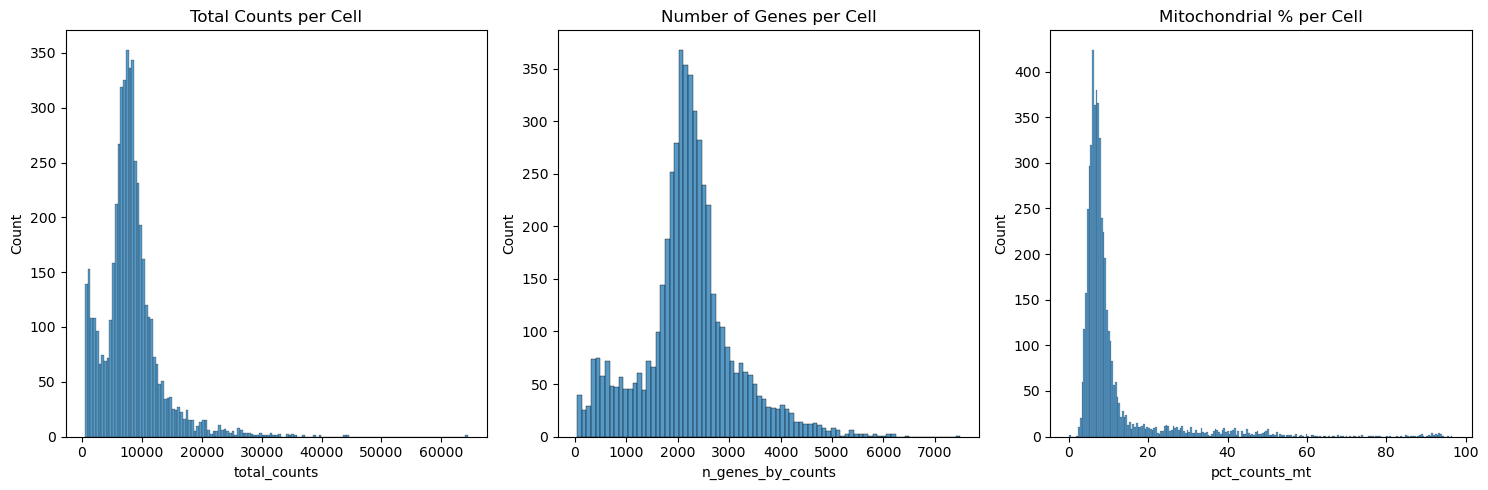

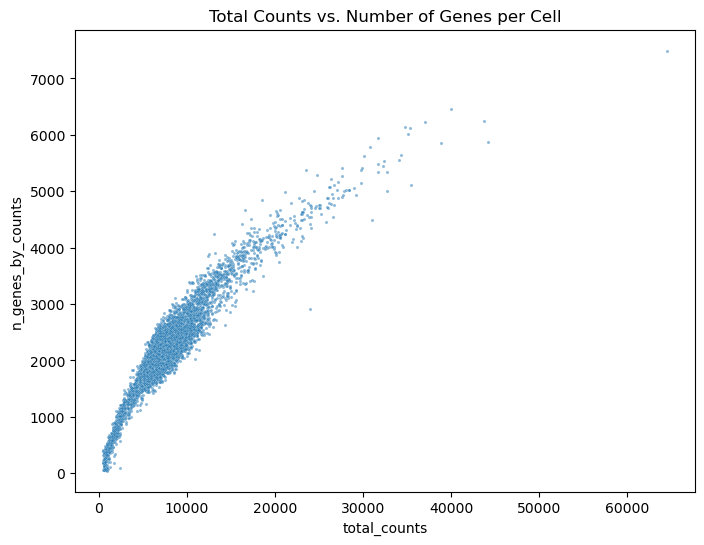

In [19]:
# Cell 6: Visualize QC metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting area: We want three plots side-by-side.
# plt.rcParams is used to set global parameters for matplotlib, like figure size.
plt.rcParams["figure.figsize"] = (15, 5) # Sets the width to 15 inches and height to 5 inches for the entire figure.

# Create a figure with 1 row and 3 columns of subplots.
# fig: The entire figure object.
# axes: An array of individual subplot (axes) objects. We can access them like axes[0], axes[1], axes[2].
fig, axes = plt.subplots(1, 3)

# Plot 1: Histogram of 'total_counts' (total RNA molecules per cell)
# sns.histplot: Seaborn function for plotting histograms.
#   data=adata.obs: We are plotting data from the cell metadata table (adata.obs).
#   x='total_counts': The column we want to plot on the x-axis.
#   kde=False: Do not plot the kernel density estimate (just bars).
#   ax=axes[0]: Plot this histogram on the first subplot.
sns.histplot(adata.obs['total_counts'], kde=False, ax=axes[0])
axes[0].set_title('Total Counts per Cell')

# Plot 2: Histogram of 'n_genes_by_counts' (number of genes detected per cell)
sns.histplot(adata.obs['n_genes_by_counts'], kde=False, ax=axes[1])
axes[1].set_title('Number of Genes per Cell')

# Plot 3: Histogram of 'pct_counts_mt' (percentage of mitochondrial counts per cell)
sns.histplot(adata.obs['pct_counts_mt'], kde=False, ax=axes[2])
axes[2].set_title('Mitochondrial % per Cell')

# Adjust layout to prevent plot titles/labels from overlapping.
plt.tight_layout()
# Show the plots.
plt.show()

# Create a scatter plot of total_counts vs. n_genes_by_counts.
# This helps visualize the relationship between these two metrics and identify outliers.
# Often called a 'knee plot' or 'scatter plot of cell quality'.
plt.rcParams["figure.figsize"] = (8, 6) # Reset figure size for this single plot.
sns.scatterplot(x='total_counts', y='n_genes_by_counts', data=adata.obs, s=5, alpha=0.5)
# Explanation:
#   x='total_counts', y='n_genes_by_counts': Columns from adata.obs to plot.
#   data=adata.obs: Specifies the DataFrame to get the data from.
#   s=5: Sets the size of the markers (dots) to 5.
#   alpha=0.5: Sets the transparency of the dots to 50%.
plt.title('Total Counts vs. Number of Genes per Cell') # Set the title for the scatter plot.
plt.show() # Display the scatter plot.

In [20]:
# Cell 7: Define QC thresholds

# Store our chosen filtering thresholds in variables.
# These values are based on visual inspection of QC plots and common practices for PBMCs.

min_genes = 200     # Minimum number of genes detected per cell
max_genes = 4500    # Maximum number of genes detected per cell (to exclude potential multiplets)
min_counts = 800    # Minimum total UMI counts per cell
max_mt_pct = 10     # Maximum percentage of mitochondrial counts per cell

In [21]:
# Cell 8: Apply QC filters to the Anndata object

# Print initial dimensions before filtering
print(f"Initial AnnData object dimensions: {adata.n_obs} cells x {adata.n_vars} genes")
print("-" * 50)

# 1. Filter out cells based on total_counts
# sc.pp.filter_cells: Scanpy function to filter cells.
#   adata: The Anndata object to filter.
#   min_counts=min_counts: Keep cells with at least 'min_counts' total UMI counts.
#   max_counts=None: We are not setting an upper limit for total counts here, as 'max_genes' typically handles multiplets.
print(f"Filtering cells by total_counts (min={min_counts})...")
sc.pp.filter_cells(adata, min_counts=min_counts)
print(f"  Current dimensions after total_counts filter: {adata.n_obs} cells x {adata.n_vars} genes")

# 2. Filter out cells based on n_genes_by_counts
#   min_genes=min_genes: Keep cells with at least 'min_genes' unique genes.
#   max_genes=max_genes: Keep cells with at most 'max_genes' unique genes.
print(f"Filtering cells by n_genes_by_counts (min={min_genes})...")
sc.pp.filter_cells(adata, min_genes=min_genes)
print(f"  Current dimensions after min_genes filter: {adata.n_obs} cells x {adata.n_vars} genes")

print(f"Filtering cells by n_genes_by_counts (max={max_genes})...")
sc.pp.filter_cells(adata, max_genes=max_genes)
print(f"  Current dimensions after max_genes filter: {adata.n_obs} cells x {adata.n_vars} genes")


# 3. Filter out cells based on mitochondrial percentage
# Filter cells where 'pct_counts_mt' is greater than 'max_mt_pct'.
# Note: This is an explicit selection based on the column we created, not a direct sc.pp.filter_cells argument.
# Create a boolean mask: adata.obs['pct_counts_mt'] < max_mt_pct
# This mask is then used to select rows (cells) from the adata object.
print(f"Filtering cells by mitochondrial percentage (max={max_mt_pct}%)...")
adata = adata[adata.obs['pct_counts_mt'] < max_mt_pct, :].copy()

print(f"Final AnnData object dimensions after all cell filters: {adata.n_obs} cells x {adata.n_vars} genes")
print("-" * 50)

# Optional: Filter genes that are expressed in too few cells.
# While we focused on cell-level QC, it's also common to remove genes that are detected in very few cells,
# as they provide little information for downstream analysis and can just add noise.
# A common threshold is to keep genes expressed in at least 3-20 cells.
print(f"Filtering genes detected in too few cells (min_cells=3)...")
sc.pp.filter_genes(adata, min_cells=3)
print(f"Final AnnData object dimensions after gene filter: {adata.n_obs} cells x {adata.n_vars} genes")

# Re-calculate QC metrics after filtering cells, as the percentages and counts might have changed slightly.
print("Re-calculating QC metrics after filtering...")
sc.pp.calculate_qc_metrics(adata, inplace=True)
print("QC metrics re-calculated.")

# Print final Anndata object summary
print("\nFinal AnnData object summary after QC:")
print(adata)

Initial AnnData object dimensions: 5155 cells x 33538 genes
--------------------------------------------------
Filtering cells by total_counts (min=800)...
  Current dimensions after total_counts filter: 5070 cells x 33538 genes
Filtering cells by n_genes_by_counts (min=200)...
  Current dimensions after min_genes filter: 5055 cells x 33538 genes
Filtering cells by n_genes_by_counts (max=4500)...
  Current dimensions after max_genes filter: 4961 cells x 33538 genes
Filtering cells by mitochondrial percentage (max=10%)...
Final AnnData object dimensions after all cell filters: 3843 cells x 33538 genes
--------------------------------------------------
Filtering genes detected in too few cells (min_cells=3)...
Final AnnData object dimensions after gene filter: 3843 cells x 18372 genes
Re-calculating QC metrics after filtering...
QC metrics re-calculated.

Final AnnData object summary after QC:
AnnData object with n_obs × n_vars = 3843 × 18372
    obs: 'pct_counts_mt', 'n_genes_by_counts'

## QC Filtering Summary.

The following thresholds were applied based on visual inspection of QC plots and common practices for PBMCs:
- total_counts > 800
- n_genes_by_counts > 200
- n_genes_by_counts < 4500
- pct_counts_mt < 10



Initial number of cells and genes: 
- 5155 cells
- 33,538 genes



Final number of cells and genes:
- 3843 cells
- 18,372 genes



Number of cells and genes removed: 
- Cells removed: (1312/5155) * 100 ≈ 25.45%
- Genes removed: (15166/33538) * 100 ≈ 45.22%


In [ ]:
# Cell 9: Normalise the data

# Perform total-count normalisation to a target sum of 1e4 (10,000) counts per cell.
# This corrects for differences in sequencing depth between cells.
print("Normalizing data (total-count normalization to 10,000 counts per cell)...")
sc.pp.normalize_total(adata, target_sum=1e4)
print("Normalization complete.")

Normalizing data (total-count normalization to 10,000 counts per cell)...
Normalization complete.


In [ ]:
# Cell 10: Log-transform the normalised data

# Log-transform the normalised counts.
# This makes the distribution of counts more symmetric and handles zeros (log(x+1)).
print("Log-transforming data...")
sc.pp.log1p(adata)
print("Log-transformation complete.")

Log-transforming data...
Log-transformation complete.


In [ ]:
# Cell 11: Identify highly variable genes

# Identify highly variable genes.
# This step helps to focus on genes that contribute most to biological variation.
# Scanpy's default method for this is seurat_v3. The numbers are the default values from this method.
print("Identifying highly variable genes...")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) # Exclude genes expressed too lowly (noise) or too highly (e.g. housekeeping genes)

# Print the number of highly variable genes found
print(f"Found {np.sum(adata.var['highly_variable'])} highly variable genes.")
print("Highly variable gene identification complete.")

Identifying highly variable genes...
Found 1869 highly variable genes.
Highly variable gene identification complete.


In [ ]:
# Cell 12: Scale the data

# For each gene, subtract the mean and divide by the standard deviation.
# This ensures that highly expressed genes don't dominate downstream analysis.
# Apply scaling only to the highly variable genes (standard practice).
# The data is capped as very low-variance genes (e.g. a gene expressed at almost 
# the same level in all cells, but with tiny fluctuations) can lead to extremely 
# large positive or negative scaled values if its standard deviation is very close to zero.
print("Scaling data...")
sc.pp.scale(adata, max_value=10) 
print("Scaling complete.")

# Confirm that the data is now normalised, log-transformed, and scaled
print("\nFinal Anndata object summary after normalization, log-transformation, and scaling:")
print(adata)

Scaling data...
Scaling complete.

Final Anndata object summary after normalization, log-transformation, and scaling:
AnnData object with n_obs × n_vars = 3843 × 18372
    obs: 'pct_counts_mt', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'


## Normalization and Scaling Summary.

Despite running QC, technical variability still may exist in the data (due to differences in sequencing depth or technical noise, for example). We, therefore, normalise the data using the following steps:
- Total count normalisation (target sum 10,000): Divide the UMI count for each cell by the total UMI count and multiply by a scale factor
- Log transformation of the normalised data using log1p: To avoid highly expressed genes from dominating the data
- Scale the data: 
    - For each gene, subtract its mean and divide by its standard deviation. This ensures that all genes contribute equally to downstream analyses based on their relative variation across cells, preventing highly expressed genes from dominating.
    - Scaled Value = (Log Normalized Count Mean of Gene) / Standard Deviation of Gene


We identified 1869 highly variable genes.



In [26]:
# Cell 13: Perform Principal Component Analysis (PCA)

# Run PCA on the scaled data.
# By default, scanpy uses the highly variable genes if they have been identified.
# If highly_variable_genes were not computed/selected, it would run on all genes.
print("Running PCA...")
sc.tl.pca(adata)
print("PCA complete. Results stored in adata.obsm['X_pca'].")

Running PCA...
PCA complete. Results stored in adata.obsm['X_pca'].


Plotting explained variance ratio...


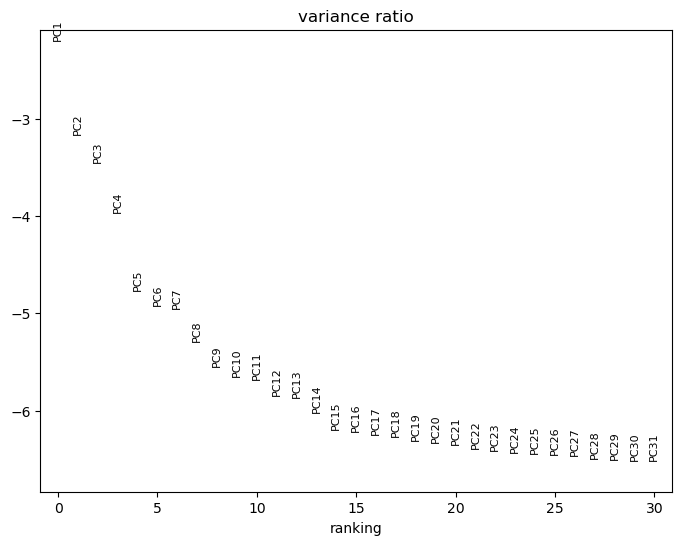

Explained variance plot generated.


In [27]:
# Cell 14: Plot the Explained Variance Ratio (Elbow Plot)

# Plot the explained variance ratio of each principal component.
# This helps in determining how many PCs to retain for downstream analysis.
print("Plotting explained variance ratio...")
sc.pl.pca_variance_ratio(adata, log=True)
print("Explained variance plot generated.")

## PCA and Dimensionality Reduction Summary.

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that transforms the data into new, uncorrelated axes called Principal Components (PCs), which capture the maximum variance in the data.


Aim: 
- To reduce the number of features (genes) for each cell while retaining as much biologically meaningful variance (differences between cells) as possible.
- When the cells are projected into a lower-dimensional space similar cells will be closer together and dissimilar cells will be further apart.


Data will be kept until PC15 after which there isn't much variation in the elbow plot (as shown above) 